In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
import folium 

# Dependency between level of pollution and the pressure 

The results of analysis of dependency between pollution level (measured by concentration of Pm10) and the air pressure are presented. The polynomial regression is performed to predict the pollution level based on the air pressure value for every recording station available in a data set. Next, the obtained coefficients are compared between the stations and the results are presented on a map.

In the next, the results for the quadratic model are presented.

In [2]:
degree = 2

In [3]:
%%time
data = pd.read_csv('/home/grzegorz/Pulpit/Projects/Airly/LDA/airly_data_full.csv')
data = data[['start_date', 'PM10', 'installation_id', 'Pressure', 'Temperature', 'air_quality_index_value']]
data.start_date = pd.to_datetime(data.start_date).reset_index(drop=True)
data = data.sort_values(by = 'start_date')
data = data.replace('None', np.nan)
dates = pd.date_range(start='2019-11-15T00:00:00Z', end='2020-01-16T23:00:00Z', freq='1H')
days = len(dates)
installations = data.installation_id.drop_duplicates().tolist()
inst = len(installations)
tmp = []
for installation in installations:
    df = {'start_date': dates, 'installation_id': np.repeat(installation, days)}
    tmp.append(pd.DataFrame(df))
tmp = pd.concat(tmp)
tmp = tmp.set_index(['start_date', 'installation_id'])
data = data.set_index(['start_date', 'installation_id'])
data = tmp.join(data, on = ['start_date', 'installation_id'], how='left')
data = data.reset_index(drop=False)
data.PM10 = data.PM10.astype(float)
data.Pressure = data.Pressure.astype(float)
data.Temperature = data.Temperature.astype(float)
data.air_quality_index_value = data.air_quality_index_value.astype(float)
tmp = []
for installation in installations:
    df = data[data.installation_id == installation]
    df = df.sort_values(by='start_date')
    df['PM10'] = df['PM10'].interpolate().interpolate(method='pad')
    df['Pressure'] = df['Pressure'].interpolate().interpolate(method='pad')
    df['Temperature'] = df['Temperature'].interpolate().interpolate(method='pad')
    df['air_quality_index_value'] = df['air_quality_index_value'].interpolate().interpolate(method='pad')
    tmp.append(df)
data = pd.concat(tmp)
ix = data.groupby('installation_id').count().sort_values(by='PM10')[data.groupby('installation_id').count().sort_values(by='PM10').PM10 > 1500].index.tolist()
data = data[data.installation_id.isin(ix)]
data = data[data.start_date > pd.to_datetime('2019-11-15T20:00:00Z')]
data = data.dropna()

CPU times: user 33 s, sys: 776 ms, total: 33.7 s
Wall time: 21.2 s


In [4]:
data.shape

(1324361, 6)

In [5]:
installations = data.installation_id.drop_duplicates().tolist()
count = data.groupby('installation_id').count().sort_values(by='PM10')
count = count[count.PM10 > 100]
count = count.index.tolist()
installations = list(set(installations).intersection(set(count)))
len(installations)

876

In [6]:
polynomial_features= PolynomialFeatures(degree=degree)

In [7]:
def polynomial_regression(data, installation):
    tmp = data[data.installation_id == installation]
    PR = LinearRegression(n_jobs=1)
    x = polynomial_features.fit_transform(np.array(tmp.Pressure).reshape(-1, 1))
    y = tmp.PM10
    PR.fit(x, y)
    return PR.coef_, installation

In [8]:
%%time
coeffs = []
for i in installations:
    c, _ = polynomial_regression(data, i)
    coeffs.append(c)
beta0 = [coeffs[i][0] for i in range(len(coeffs))]
beta1 = [coeffs[i][1] for i in range(len(coeffs))]
if degree == 2:
    beta2 = [coeffs[i][2] for i in range(len(coeffs))]
else:
    beta2 = [0 for i in range(len(coeffs))]

CPU times: user 11.8 s, sys: 212 ms, total: 12 s
Wall time: 2.01 s


In [9]:
d = {'installation_id': installations, 'beta0': beta0, 'beta1': beta1, 'beta2': beta2}
coeffs = pd.DataFrame(d)

A summary of obtained results is presented in a table below. The values for a slope coefficient vary between -6.32 and 5.22. The values for a quadratic term are small, with the average value of -0.01. Without the prior expert knowledge, it is hard to hypothesize about the expected corellation between pressure and air pollution

In [10]:
coeffs.describe()

,installation_id,beta0,beta1,beta2
count,876.000000,876.0,876.000000,876.000000
mean,4771.784247,0.0,22.722752,-0.010948
std,3423.544233,0.0,338.945237,0.166861
min,207.000000,0.0,-1684.065900,-3.733192
25%,2126.750000,0.0,-21.383389,-0.014776
50%,3362.500000,0.0,2.533856,-0.000945
75%,7768.750000,0.0,30.367982,0.010945
max,10582.000000,0.0,7583.137653,0.832295


The scatter plot of slope coefficients for every recording station is presented with a line indicating the 0 value. Most of the values are located above the 0, however a siginificant part points is below 0. The estimated values do not exhibit any heterogenity constituting 1 cluster.

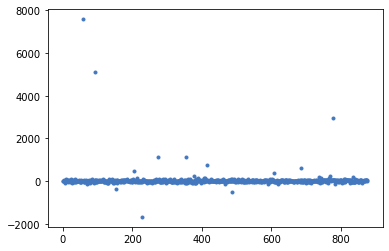

In [11]:
plt.plot(coeffs.beta1, '.', c="#4378BF")
plt.hlines(y=0, xmin=0, xmax=len(coeffs.beta1), colors="#F05A71")

In [12]:
installations_list = pd.read_csv('installations.csv')

In [13]:
installations_list = installations_list[['installation_id', 'elevation', 'geolocation_latitude', 'geolocation_longitude']]
installations_list = installations_list.set_index('installation_id')
installations_list = installations_list[installations_list.index.isin(installations)]

In [14]:
# scaler = StandardScaler()
# coeffs_cl = coeffs[coeffs.set_index('installation_id').index.isin(installations_list.index.tolist())]
# coeff_np = scaler.fit_transform(np.array(coeffs_cl.iloc[:, 1:]))
# epss = np.linspace(0.01, 0.05, 6)
# n_clusters = [i+1 for i in range(6)]

In [15]:
# clustering_dbscan = []
# clustering_kmeans = []
# for i in range(len(epss)):
#     clustering_dbscan.append(DBSCAN(eps=epss[i], min_samples=5, algorithm='brute', n_jobs=1).fit_predict(coeff_np))
#     clustering_kmeans.append(KMeans(n_clusters=n_clusters[i], n_jobs=1).fit_predict(coeff_np))

In [16]:
installations_list = coeffs.join(installations_list, on = 'installation_id', how='right')
installations_list['color'] = np.where(installations_list.beta1 >= 0, "#F05A71", "#4378BF")

In [17]:
geolocation_latitude_center = installations_list.geolocation_latitude.mean()
geolocation_longitude_center = installations_list.geolocation_longitude.mean()

The map below shows the location of stations in a neighborhood of Cracow. Blue points indicates the stations with negative corellation of pollution with pressure, whereas the red points indicate the locations with positive corellation. It can be concluded that the recording stations with positive correlation, concentrate in a cities like Cracow and the locations of recording stations with negative corellation are located rather outside bigger cities. This behaviour can be driven by a differnet main sources of pollution in the air. For cities, it comes mostly from a transport, outside the cities it is driven by the house heating.

In [18]:
col = ["#4378BF", "#46BAC2", "#8BDCBE", "#AE2C87", "#FFA58C", "#F05A71"]
map_PM10 = folium.Map(location=[geolocation_latitude_center,geolocation_longitude_center], zoom_start=10) 

for lat,lan, i in zip(installations_list.geolocation_latitude.tolist(), installations_list.geolocation_longitude.tolist(), installations_list.color):  
    folium.CircleMarker(location=[lat,lan],
                        radius=5,
                        weight=2,
                        color=i,
                        fill_color=i,
                        fill_opacity=0.7).add_to(map_PM10)
map_PM10